In [3]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS

import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import seaborn as sns

In [6]:
polls = pd.read_csv('data/STATS271_poll_data.csv')
counties = pd.read_csv('data/cleaned_data.csv')
n_counties = counties.shape[0]
may = polls[polls['month'] == 5]

In [7]:
top100_black = counties.sort_values('black_pct',ascending = False).iloc[:100,]
top100_hispanic = counties.sort_values('hispanic_pct',ascending = False).iloc[:100,]


In [8]:
counties 

,FIPS,county,state,hesitant_pct,hesitant_unsure_pct,strongly_hesitant_pct,SVI,concern_level,fully_vaxxed_pct,hispanic_pct,NA_pct,black_pct,white_pct,aapi_pct,somewhat_hesitant_pct,eager_pct,eager_over_no,somewhat_over_no
0,1079,"Lawrence County, Alabama",ALABAMA,0.1913,0.2762,0.0999,0.50,0.80,0.324,0.0219,0.0560,0.1058,0.7649,0.0028,0.1763,0.7238,7.245245,1.764765
1,1107,"Pickens County, Alabama",ALABAMA,0.1825,0.2688,0.0917,0.92,0.78,0.294,0.0487,0.0014,0.3984,0.5365,0.0012,0.1771,0.7312,7.973828,1.931298
2,1035,"Conecuh County, Alabama",ALABAMA,0.1915,0.2943,0.0963,0.81,0.89,0.289,0.0068,0.0020,0.4776,0.5005,0.0045,0.1980,0.7057,7.328141,2.056075
3,4021,"Pinal County, Arizona",ARIZONA,0.1422,0.2077,0.0877,0.86,0.87,0.340,0.3016,0.0430,0.0408,0.5679,0.0187,0.1200,0.7923,9.034208,1.368301
4,1067,"Henry County, Alabama",ALABAMA,0.1929,0.2871,0.0996,0.55,0.65,0.311,0.0262,0.0018,0.2655,0.6917,0.0050,0.1875,0.7129,7.157631,1.882530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3137,55109,"St. Croix County, Wisconsin",WISCONSIN,0.0917,0.1380,0.0628,0.01,0.09,0.356,0.0240,0.0019,0.0080,0.9391,0.0097,0.0752,0.8620,13.726115,1.197452
3138,55121,"Trempealeau County, Wisconsin",WISCONSIN,0.0991,0.1530,0.0690,0.28,0.31,0.547,0.0840,0.0034,0.0051,0.8953,0.0043,0.0840,0.8470,12.275362,1.217391
3139,55087,"Outagamie County, Wisconsin",WISCONSIN,0.0943,0.1434,0.0652,0.10,0.04,0.474,0.0431,0.0148,0.0139,0.8753,0.0348,0.0782,0.8566,13.138037,1.199387
3140,55103,"Richland County, Wisconsin",WISCONSIN,0.0986,0.1520,0.0688,0.31,0.46,0.497,0.0232,0.0038,0.0088,0.9459,0.0071,0.0832,0.8480,12.325581,1.209302


In [9]:
counties.columns

Index(['FIPS', 'county', 'state', 'hesitant_pct', 'hesitant_unsure_pct',
       'strongly_hesitant_pct', 'SVI', 'concern_level', 'fully_vaxxed_pct',
       'hispanic_pct', 'NA_pct', 'black_pct', 'white_pct', 'aapi_pct',
       'somewhat_hesitant_pct', 'eager_pct', 'eager_over_no',
       'somewhat_over_no'],
      dtype='object')

In [66]:
def log_means_sds(counties):
    response_cols = ['eager_over_no', 'somewhat_over_no']
    responses = counties[response_cols]
    n_response = len(response_cols)
    Y = np.log(responses.values)
    #Y = responses.values
    log_means = np.median(Y, axis=0)
    log_sds = np.std(Y, axis=0)
    print(log_means)
    print(log_sds)
    return log_means, log_sds

In [67]:
black_means, black_sds = log_means_sds(top100_black)

[2.19039625 0.78962764]
[0.3019018  0.11998323]


In [68]:
hisp_means, hisp_sds = log_means_sds(top100_hispanic)

[2.69223018 0.5404008 ]
[0.16143274 0.18157414]


In [13]:
response_cols = ['eager_over_no', 'somewhat_over_no']
responses = counties[response_cols]
n_response = len(response_cols)
Y = np.log(responses.values)

In [14]:
log_means = np.mean(Y, axis=0)
log_sds = np.std(Y, axis=0)

In [15]:
feature_cols = ['hispanic_pct', 'black_pct', 'white_pct', 'SVI']
n_features = len(feature_cols)
features = counties[feature_cols]

W_mat = np.zeros((n_features, n_response))

(array([116., 284., 521., 577., 948., 398., 175.,  80.,  36.,   7.]),
 array([1.35217382, 1.6081799 , 1.86418598, 2.12019206, 2.37619814,
        2.63220422, 2.8882103 , 3.14421638, 3.40022246, 3.65622854,
        3.91223462]),
 <a list of 10 Patch objects>)

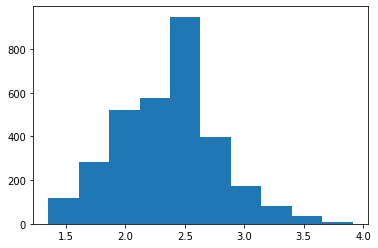

In [16]:
plt.hist(np.log(counties['eager_over_no']))

(array([  2.,  18.,   5., 231., 418., 552., 782., 746., 373.,  15.]),
 array([-0.6985453 , -0.51809357, -0.33764184, -0.1571901 ,  0.02326163,
         0.20371336,  0.38416509,  0.56461683,  0.74506856,  0.92552029,
         1.10597203]),
 <a list of 10 Patch objects>)

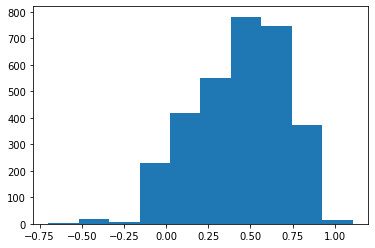

In [17]:
plt.hist(np.log(counties['somewhat_over_no']))

In [18]:
counties.drop('FIPS', axis=1)[feature_cols + response_cols].corr()

,hispanic_pct,black_pct,white_pct,SVI,eager_over_no,somewhat_over_no
hispanic_pct,1.000000,-0.115655,-0.601836,0.312908,0.228202,0.119327
black_pct,-0.115655,1.000000,-0.591361,0.475810,-0.043075,0.477057
white_pct,-0.601836,-0.591361,1.000000,-0.614748,-0.130603,-0.358495
SVI,0.312908,0.475810,-0.614748,1.000000,-0.228558,0.209659
eager_over_no,0.228202,-0.043075,-0.130603,-0.228558,1.000000,0.448324
somewhat_over_no,0.119327,0.477057,-0.358495,0.209659,0.448324,1.000000


In [19]:
def get_month_subgroup(polls ,month, subgroup):
    may = polls[polls['month'] == month]
    may_black = may[may['subgroup'] == subgroup]
    counts = np.array(may_black[data_cols]).sum(axis=0)
    return may_black, counts

In [20]:
data_cols = ['num_yes', 'num_hesitant', 'num_no']

In [21]:

may_black, black_tot_may = get_month_subgroup(polls, 5, 'black')
apr_black, black_tot_apr = get_month_subgroup(polls, 4, 'black')
mar_black, black_tot_mar = get_month_subgroup(polls, 3, 'black')
feb_black, black_tot_feb = get_month_subgroup(polls, 2, 'black')

black = np.row_stack([black_tot_apr, black_tot_may])
may_hisp, hisp_tot_may = get_month_subgroup(polls, 5, 'hispanic')
apr_hisp, hisp_tot_apr = get_month_subgroup(polls, 4, 'hispanic')
mar_hisp, hisp_tot_mar = get_month_subgroup(polls, 3, 'hispanic')
feb_hisp, hisp_tot_feb = get_month_subgroup(polls, 2, 'hispanic')


black_counts = np.vstack([black_tot_may, black_tot_apr, 
                          black_tot_mar, black_tot_feb])

In [125]:
model_dict = {}
for prior_sample_weight in [50,200,500,1000]:
    with pm.Model() as dirichlet_model:

        k = 3

        use_lognormal = True

        sigma_1 = pm.InverseGamma("sigma1", 1,1)
        sigma_2 = pm.InverseGamma("sigma2", 1,1)


        if use_lognormal:

            beta_1 = pm.Lognormal('beta_1', mu=black_means[0], sigma=sigma_1)
            beta_2 = pm.Lognormal('beta_2', mu=black_means[1], sigma=sigma_2)

            a1 =  beta_1 / (beta_1 + beta_2 + 1)
            a2 =  beta_2 / (beta_1 + beta_2 + 1)
            a3 = 1 / (beta_1 + beta_2 + 1)

        else:

            beta_1 = pm.Normal('beta_1', mu=black_means[0], sigma=sigma_1)    
            beta_2 = pm.Normal('beta_2', mu=black_means[1], sigma=sigma_2)

            exp_b1 = pm.math.exp(beta_1)
            exp_b2 = pm.math.exp(beta_2)

            a1 =  exp_b1 / (exp_b1 + exp_b2 + 1)
            a2 =  exp_b2 / (exp_b1 + exp_b2 + 1)
            a3 = 1 / (exp_b1 + exp_b2 + 1)


        arr = [a1,a2,a3]

       # arr*=prior_weight

        arr = [i*prior_sample_weight for i in arr]


    #     prop_black = pm.Dirichlet(
    #         "prop_black",
    #         a=arr,
    #         shape=(4,3)
    #     )

    #     black_mn = pm.Multinomial("black_multinomial",
    #                               n=4, 
    #                               p=prop_black,
    #                               observed=black_counts)

        prop_black_feb = pm.Dirichlet(
            "proportions_black_feb",
            a=arr,#.astype('float32'),
            shape=(3,),
            testval=[0.1, 0.1, 0.1]
        )
        prop_black_mar = pm.Dirichlet(
            "proportions_black_mar",
            a=arr,#.astype('float32'),
            shape=(3,),
            testval=[0.1, 0.1, 0.1]
        )


        prop_black_apr = pm.Dirichlet(
            "proportions_black_apr",
            a=arr,#.astype('float32'),
            shape=(3,),
            testval=[0.1, 0.1, 0.1]
        )

        prop_black_may = pm.Dirichlet(
            "proportions_black_may",
            a=arr,#.astype('float32'),
            shape=(3,),
            testval=[0.1, 0.1, 0.1]
        )
        
        
      
        

        black_feb_counts = pm.Multinomial(
                        "black_feb_counts",
                        n=black_tot_feb.sum(),
                        p=prop_black_feb,
                        observed=black_tot_feb)

        black_mar_counts = pm.Multinomial(
                        "black_mar_counts",
                        n=black_tot_mar.sum(),
                        p=prop_black_mar,
                        observed=black_tot_mar)


        black_apr_counts = pm.Multinomial(
                        "black_apr_counts",
                        n=black_tot_apr.sum(),
                        p=prop_black_apr,
                        observed=black_tot_apr)

        black_may_counts = pm.Multinomial(
                        "black_may_counts",
                        n=black_tot_may.sum(),
                        p=prop_black_may,
                        observed=black_tot_may)
        
        


        pm.Deterministic("diff_black", prop_black_may-prop_black_apr)
        pm.Deterministic("diff_black_mar", prop_black_may-prop_black_mar)
        model_dict[prior_sample_weight] = dirichlet_model

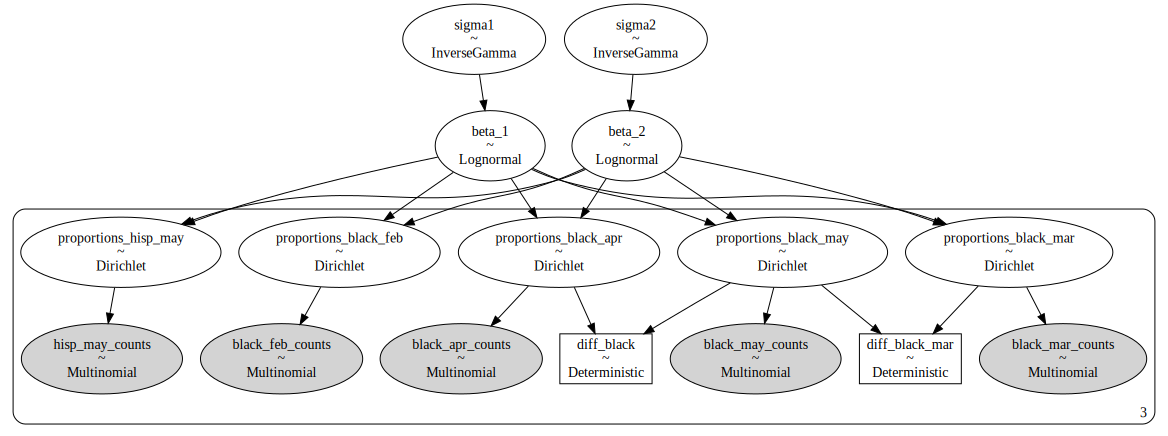

In [126]:
pm.model_to_graphviz(model_dict[50])

In [83]:
trace_dict = {}
for k in model_dict:
    with model_dict[k]:
        trace_dirichlet = pm.sample(draws=1000, chains=4, #step=pm.Metropolis(),
                                    return_inferencedata=True)
        trace_dict[k] = trace_dirichlet

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [proportions_black_may, proportions_black_apr, proportions_black_mar, proportions_black_feb, beta_2, beta_1, sigma2, sigma1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [proportions_black_may, proportions_black_apr, proportions_black_mar, proportions_black_feb, beta_2, beta_1, sigma2, sigma1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [proportions_black_may, proportions_black_apr, proportions_black_mar, proportions_black_feb, beta_2, beta_1, sigma2, sigma1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [proportions_black_may, proportions_black_apr, proportions_black_mar, proportions_black_feb, beta_2, beta_1, sigma2, sigma1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.


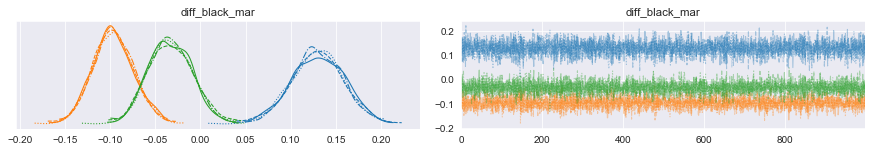

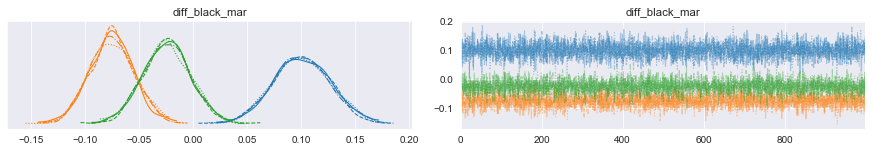

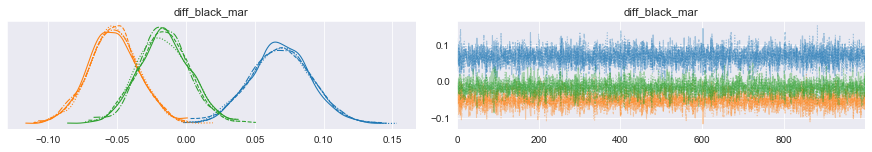

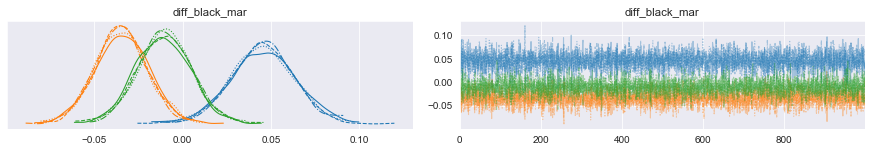

In [109]:
for k in trace_dict:
    ax = az.plot_trace(data=trace_dict[k], var_names=['diff_black_mar'])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a5fbc26d0>,
      dtype=object)

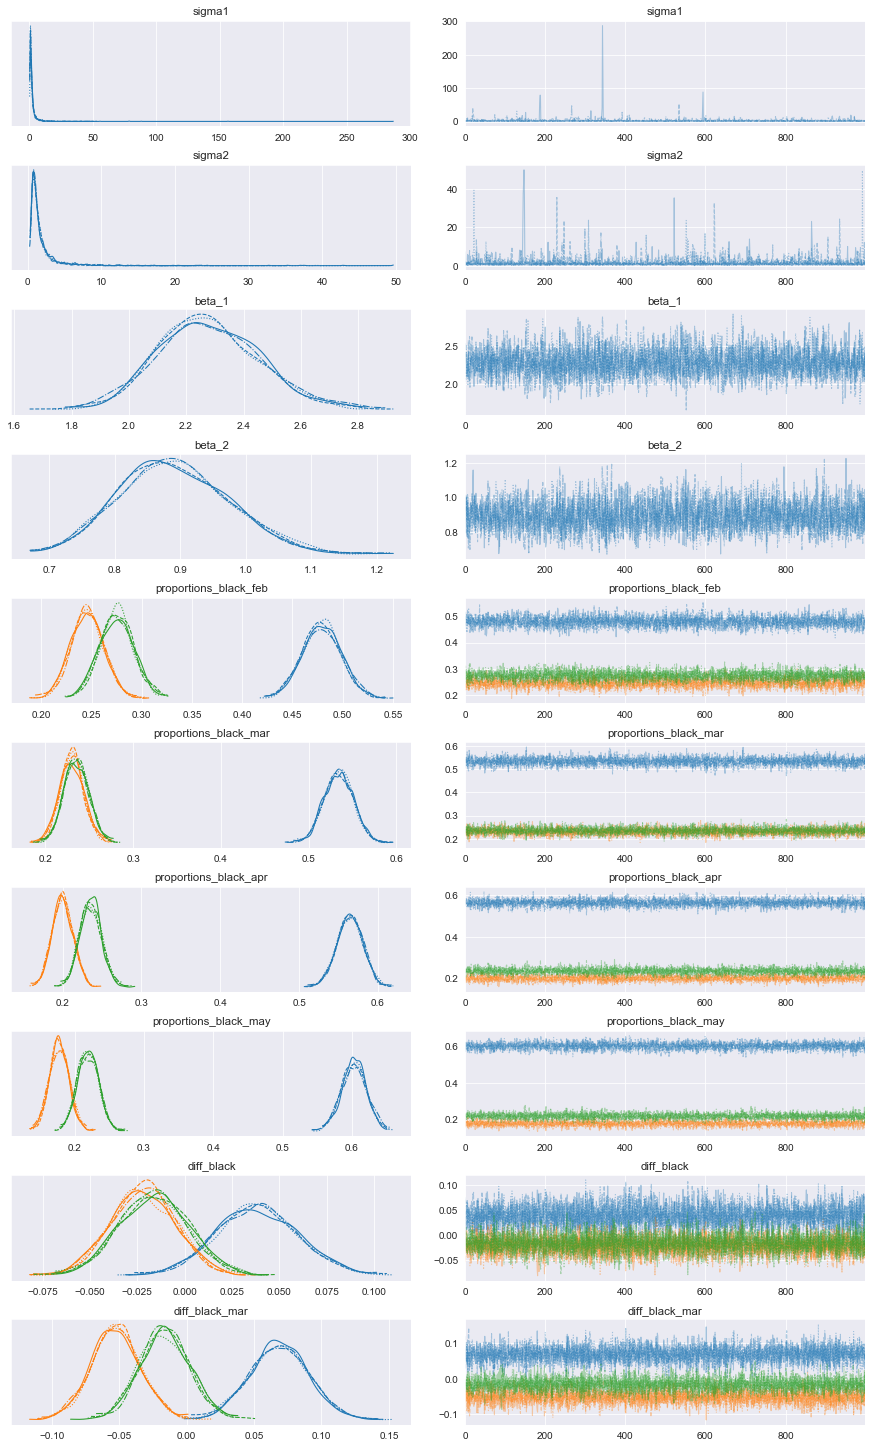

In [124]:
az.plot_trace(data=trace_dict[500])

In [49]:
summary = az.summary(trace_dirichlet, hdi_prob=0.9)

In [172]:
for k in trace_dict:
    summary = az.summary(trace_dict[k], hdi_prob=0.9)
    inds = [i for i in range(len(summary.index)) if 
            'proportions_black_apr' in summary.index[i]
             or 'diff_black_mar' in summary.index[i]]
    print(f'{k}:')
    print(summary.iloc[inds,])


50:
                           mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
proportions_black_apr[0]  0.577  0.019   0.547    0.609        0.0      0.0   
proportions_black_apr[1]  0.191  0.015   0.167    0.216        0.0      0.0   
proportions_black_apr[2]  0.232  0.016   0.204    0.256        0.0      0.0   
diff_black_mar[0]         0.130  0.029   0.086    0.181        0.0      0.0   
diff_black_mar[1]        -0.097  0.022  -0.132   -0.058        0.0      0.0   
diff_black_mar[2]        -0.033  0.024  -0.072    0.007        0.0      0.0   

                          ess_bulk  ess_tail  r_hat  
proportions_black_apr[0]    4968.0    3363.0    1.0  
proportions_black_apr[1]    4850.0    2778.0    1.0  
proportions_black_apr[2]    5435.0    2718.0    1.0  
diff_black_mar[0]           5622.0    2730.0    1.0  
diff_black_mar[1]           5189.0    3096.0    1.0  
diff_black_mar[2]           5892.0    2606.0    1.0  
200:
                           mean     sd  hdi_5%  hdi_95%  mc

In [115]:
summary = az.summary(trace_dict[500], hdi_prob=0.9)

In [116]:
needed_rows = [i for i in summary.index if 'proportions_' in i]
to_plot = summary.filter(needed_rows, axis=0)[['mean', 'sd', 'hdi_5%', 'hdi_95%']]
to_plot['month'] = [2]*3 + [3]*3 + [4]*3 + [5]*3
to_plot['label'] = ['eager', 'hesitant', 'hard_no']*4

In [117]:
sns.set_style("darkgrid")

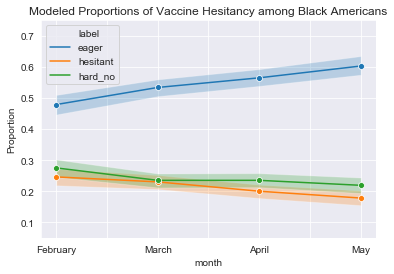

In [118]:
g = sns.lineplot(data=to_plot, x='month', y='mean', hue='label', ci='sd', marker='o', err_style='band')
g.set_xticklabels(['','February', '', 'March', '', 'April', '', 'May'])
g.set(ylim=(0.05,0.75), ylabel='Proportion', title='Modeled Proportions of Vaccine Hesitancy among Black Americans')
#g.fill_between(to_plot['month'], to_plot['hdi_5%'].values, to_plot['hdi_95%'].values, alpha=0.2) 
lvls = to_plot.label.unique()
for i in lvls:
    g.fill_between(x = to_plot[to_plot['label']==i]["month"],
                y1=to_plot[to_plot['label']==i]["hdi_5%"], 
                y2=to_plot[to_plot['label']==i]["hdi_95%"],label=i,
                  alpha=0.25)

In [119]:
lvls = to_plot.label.unique()
for i in lvls:
    g.errorbar(x = to_plot[to_plot['label']==i]["month"],
                y=to_plot[to_plot['label']==i]["mean"], 
                yerr=to_plot[to_plot['label']==i]["sd"],label=i)

In [120]:
to_plot['hdi_5%'].values

array([0.447, 0.219, 0.246, 0.506, 0.207, 0.212, 0.539, 0.178, 0.213,
       0.575, 0.155, 0.194])

In [121]:
fmri = sns.load_dataset("fmri")

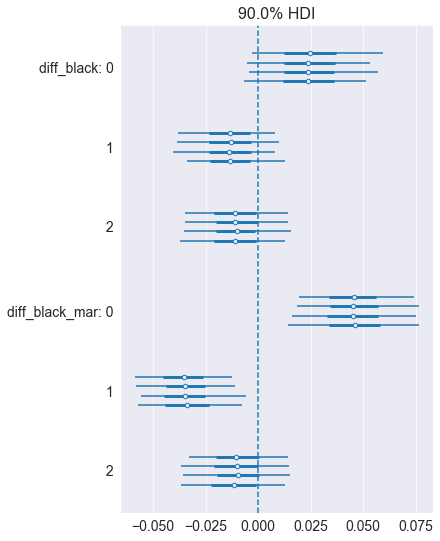

In [122]:
az.plot_forest(trace_dirichlet, var_names=["diff_black", "diff_black_mar"], hdi_prob=0.9)
plt.axvline(0, linestyle='--')
#plt.yticks(['Eager', 'Hesitant', 'Hard no'])

In [123]:
with dirichlet_model:
    ppc = pm.fast_sample_posterior_predictive(trace_dirichlet, keep_size=True)

In [335]:
az.forest_plot(ppc)

AttributeError: module 'arviz' has no attribute 'forest_plot'

In [166]:
model_dict_h = {}
for w in [50, 200, 500, 1000]:
    
    with pm.Model() as hispanic_model:


        sigma_1 = pm.InverseGamma("sigma1", 1,1)
        sigma_2 = pm.InverseGamma("sigma2", 1,1)


        beta_1 = pm.Lognormal('beta_1', mu=hisp_means[0], sigma=sigma_1)
        beta_2 = pm.Lognormal('beta_2', mu=hisp_means[1], sigma=sigma_2)

        a1 =  beta_1 / (beta_1 + beta_2 + 1)
        a2 =  beta_2 / (beta_1 + beta_2 + 1)
        a3 = 1 / (beta_1 + beta_2 + 1)

        arr = [a1,a2,a3]
        arr = [i*w for i in arr]

        prop_hisp_feb = pm.Dirichlet(
            "proportions_hisp_feb",
            a=arr,#_default,#.astype('float32'),
            shape=(3,)#,
            #testval=[0.1, 0.1, 0.1]
        )



        prop_hisp_mar = pm.Dirichlet(
            "proportions_hisp_mar",
            a=arr,#_default,#.astype('float32'),
            shape=(3,)#,
            #testval=[0.1, 0.1, 0.1]
        )


        prop_hisp_apr = pm.Dirichlet(
            "proportions_hisp_apr",
            a=arr,#_default,#.astype('float32'),
            shape=(3,)#,
         #   testval=[0.1, 0.1, 0.1]
        )

        prop_hisp_may = pm.Dirichlet(
            "proportions_hisp_may",
            a=arr,#_default,#.astype('float32'),
            shape=(3,)
            #,
            #testval=[0.1, 0.1, 0.1]
        )




        hisp_feb_counts = pm.Multinomial(
                        "hisp_feb_counts",
                        n=hisp_tot_feb.sum(),
                        p=prop_hisp_feb,
                        observed=hisp_tot_feb)


        hisp_mar_counts = pm.Multinomial(
                        "hisp_mar_counts",
                        n=hisp_tot_mar.sum(),
                        p=prop_hisp_mar,
                        observed=hisp_tot_mar)


        hisp_apr_counts = pm.Multinomial(
                        "hisp_apr_counts",
                        n=hisp_tot_apr.sum(),
                        p=prop_hisp_apr,
                        observed=hisp_tot_apr)

        hisp_may_counts = pm.Multinomial(
                        "hisp_may_counts",
                        n=hisp_tot_may.sum(),
                        p=prop_hisp_may,
                        observed=hisp_tot_may)


        pm.Deterministic("diff_hisp", prop_hisp_may-prop_hisp_apr)
        pm.Deterministic("diff_hisp_mar", prop_hisp_may-prop_hisp_mar)

        model_dict_h[w] = hispanic_model


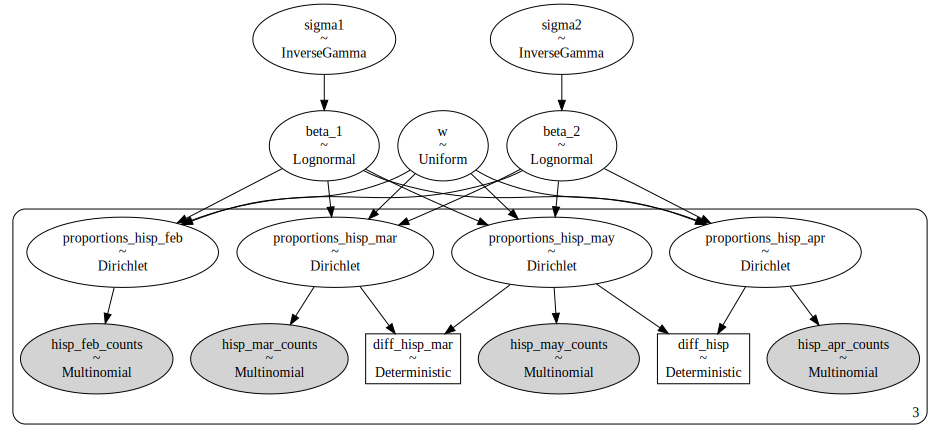

In [161]:
pm.model_to_graphviz(hispanic_model)

In [167]:
trace_dict_h = {}
for k in model_dict_h:
    with model_dict_h[k]:
        trace_hisp = pm.sample(draws=1000, chains=4,# step=pm.Metropolis(),
                                    return_inferencedata=True)
        trace_dict_h[k] = trace_hisp

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [proportions_hisp_may, proportions_hisp_apr, proportions_hisp_mar, proportions_hisp_feb, beta_2, beta_1, sigma2, sigma1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [proportions_hisp_may, proportions_hisp_apr, proportions_hisp_mar, proportions_hisp_feb, beta_2, beta_1, sigma2, sigma1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [proportions_hisp_may, proportions_hisp_apr, proportions_hisp_mar, proportions_hisp_feb, beta_2, beta_1, sigma2, sigma1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 22 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [proportions_hisp_may, proportions_hisp_apr, proportions_hisp_mar, proportions_hisp_feb, beta_2, beta_1, sigma2, sigma1]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a718b9e10>,
      dtype=object)

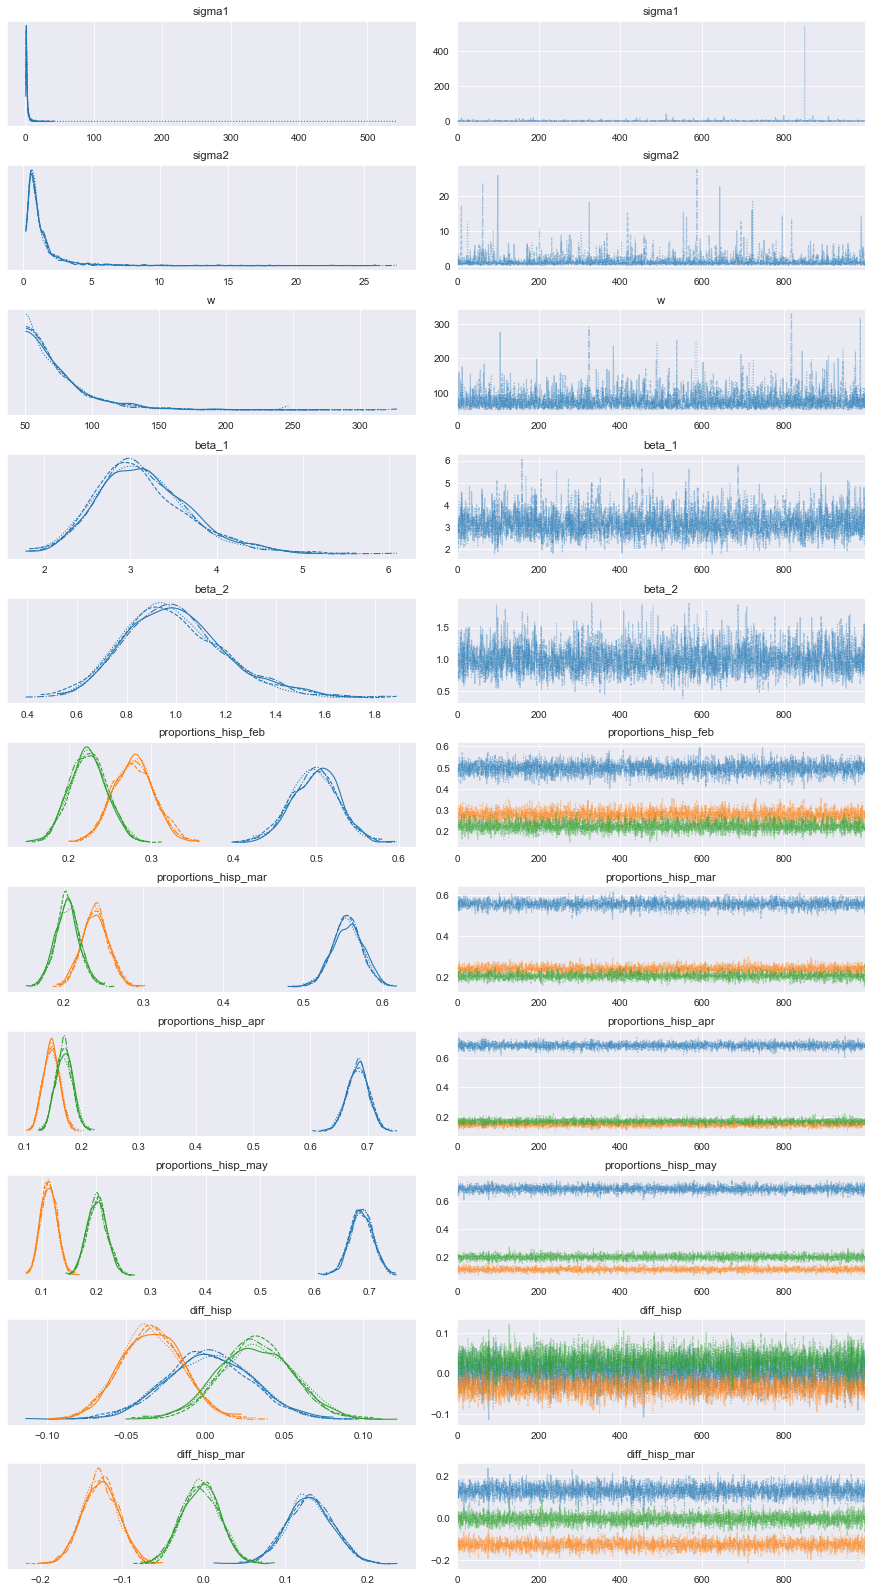

In [163]:
az.plot_trace(data=trace_hisp)

In [170]:
for k in trace_dict_h:
    summary = az.summary(trace_dict_h[k], hdi_prob=0.9)
    inds = [i for i in range(len(summary.index)) if 
            'proportions_hisp_feb' in summary.index[i]
             or 'diff_hisp_mar' in summary.index[i]]
    print(f'{k}:')
    print(summary.iloc[inds,])

50:
                          mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_sd  \
proportions_hisp_feb[0]  0.490  0.027   0.445    0.534        0.0      0.0   
proportions_hisp_feb[1]  0.285  0.025   0.245    0.326        0.0      0.0   
proportions_hisp_feb[2]  0.225  0.022   0.189    0.261        0.0      0.0   
diff_hisp_mar[0]         0.136  0.029   0.086    0.180        0.0      0.0   
diff_hisp_mar[1]        -0.132  0.022  -0.168   -0.097        0.0      0.0   
diff_hisp_mar[2]        -0.004  0.024  -0.044    0.036        0.0      0.0   

                         ess_bulk  ess_tail  r_hat  
proportions_hisp_feb[0]    4749.0    3336.0    1.0  
proportions_hisp_feb[1]    4754.0    3189.0    1.0  
proportions_hisp_feb[2]    5196.0    3255.0    1.0  
diff_hisp_mar[0]           5456.0    3422.0    1.0  
diff_hisp_mar[1]           4876.0    2801.0    1.0  
diff_hisp_mar[2]           6121.0    2896.0    1.0  
200:
                          mean     sd  hdi_5%  hdi_95%  mcse_mean  mcse_s

In [152]:
with hispanic_model:
    ppc = pm.fast_sample_posterior_predictive(trace_hisp, keep_size=True)
trace_hisp.extend(az.from_dict(posterior_predictive=ppc))


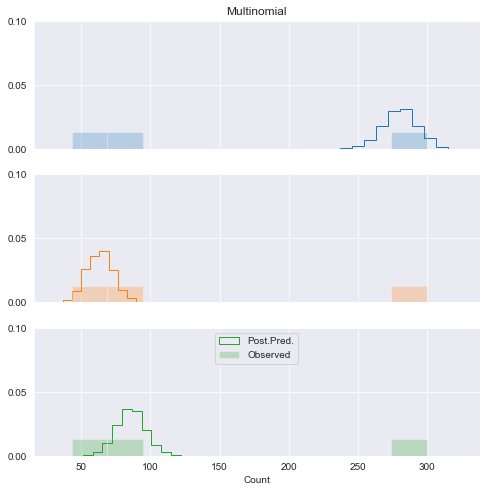

In [155]:
cmap = plt.get_cmap("tab10")

fig, axs = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(8, 8))
for j, row in enumerate(axs):
    c = cmap(j)
    for _trace, ax in zip([trace_hisp], [row]):
        ax.hist(
            _trace.posterior_predictive.hisp_may_counts[:, :, j].values.flatten(),
            histtype="step",
            color=c,
            density=True,
            label="Post.Pred.",
        )
        ax.hist(
            (_trace.observed_data.hisp_may_counts.values.flatten()),
            color=c,
            density=True,
            alpha=0.25,
            label="Observed",
        )

axs[-1].legend(loc="upper center", fontsize=10)
axs[0].set_title("Multinomial")
axs[-1].set_xlabel("Count")
axs[-1].set_yticks([0, 0.05, 0.1])
axs[-1].set_ylim(0, 0.05)
ax.set_ylim(0, 0.1);                

In [156]:
_trace.observed_data.hisp_may_counts.values.flatten()

array([300,  43,  87], dtype=int32)

In [164]:
summary_hisp = az.summary(trace_hisp, hdi_prob=0.9)
summary_hisp

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma1,2.545,8.955,0.490,4.533,0.149,0.105,4041.0,2062.0,1.0
sigma2,1.351,1.656,0.185,2.638,0.032,0.023,3914.0,2772.0,1.0
w,75.380,26.689,50.022,106.573,0.521,0.406,2888.0,2216.0,1.0
beta_1,3.151,0.553,2.227,3.979,0.010,0.007,3226.0,2839.0,1.0
beta_2,0.997,0.209,0.651,1.323,0.004,0.003,3205.0,2995.0,1.0
proportions_hisp_feb[0],0.498,0.028,0.451,0.543,0.000,0.000,3755.0,2824.0,1.0
proportions_hisp_feb[1],0.279,0.025,0.237,0.318,0.000,0.000,3708.0,2527.0,1.0
proportions_hisp_feb[2],0.224,0.022,0.186,0.260,0.000,0.000,5571.0,3362.0,1.0
proportions_hisp_mar[0],0.555,0.019,0.525,0.586,0.000,0.000,3520.0,2466.0,1.0
proportions_hisp_mar[1],0.240,0.016,0.213,0.266,0.000,0.000,3897.0,3131.0,1.0


['eager' 'hesitant' 'hard_no']


Text(0.5, 1.0, 'Difference in Hispanic Hesitancy: March to May')

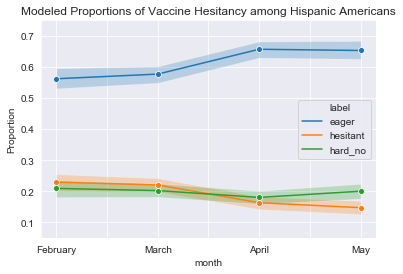

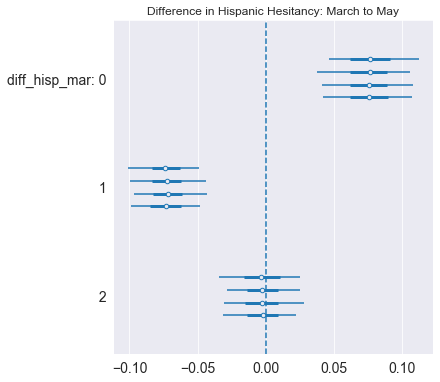

In [158]:
needed_rows = [i for i in summary_hisp.index if 'proportions_' in i]
to_plot = summary_hisp.filter(needed_rows, axis=0)[['mean', 'sd', 'hdi_5%', 'hdi_95%']]
to_plot['month'] = [2]*3 + [3]*3 + [4]*3 + [5]*3
to_plot['label'] = ['eager', 'hesitant', 'hard_no']*4

g = sns.lineplot(data=to_plot, x='month', y='mean', hue='label', ci='sd', marker='o', err_style='band')
g.set_xticklabels(['','February', '', 'March', '', 'April', '', 'May'])
g.set(ylim=(0.05,0.75), ylabel='Proportion', title='Modeled Proportions of Vaccine Hesitancy among Hispanic Americans')
#g.fill_between(to_plot['month'], to_plot['s5%'].values, to_plot['hdi_95%'].values, alpha=0.2) 
lvls = to_plot.label.unique()
print(lvls)
for i in lvls:
    g.fill_between(x = to_plot[to_plot['label']==i]["month"],
                y1=to_plot[to_plot['label']==i]["hdi_5%"], 
                y2=to_plot[to_plot['label']==i]["hdi_95%"],label=i,
                  alpha=0.25)

az.plot_forest(trace_hisp, var_names=["diff_hisp_mar"], hdi_prob=0.9)
plt.axvline(0, linestyle='--')
plt.title('Difference in Hispanic Hesitancy: March to May')

\begin{align}

\y_n &\sim Mult(\pi_{E}, \pi_{H}, \pi_{N}) \\
\beta_1 = \frac{\pi_{E}}{\pi_{N}} &\sim Lognormal(\mu_1, \sigma_1) \\
\beta_2 = \frac{\pi_{H}}{\pi_{N}} &\sim Lognormal(\mu_2, \sigma_2) \
\end{align}
where $\mu$ and $\sigma$ terms come from the means and SDs of these proportions 
for the top 100 counties for the specific subgroup.
